In [90]:
import nltk
import string
import os
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('vader_lexicon')
import PyPDF2

import spacy
import string

# Load spaCy's English model
nlp = spacy.load('en_core_web_sm')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/blaiselanphere/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/blaiselanphere/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/blaiselanphere/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/blaiselanphere/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [82]:
import matplotlib.pyplot as plt
from collections import Counter

from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd

from gensim import corpora
from gensim.models.ldamodel import LdaModel

from gensim.models import Phrases
from gensim.models.phrases import Phraser


In [31]:
# Path to your PDF file
pdf_path = 'reports/UBS.pdf'  # Adjust path if needed

# Read the PDF and extract text
with open(pdf_path, 'rb') as file:
    reader = PyPDF2.PdfReader(file)
    ubs = ""
    for page in reader.pages:
        content = page.extract_text()
        if content:
            ubs += content + "\n"

# Preview the output
print(ubs[:500])  # Print first 500 characters

Global Family 
Office Report
 2024For UBS marketing purposes
Cover image by Max Rive. Taken with a drone, it’s a panoramic view of the Romsdalen Valley,  
a 60-kilometer long valley in western Norway. The photo is a metaphor for how the family office takes  
in a broad panorama before setting a strategic path towards its objective.
Foreword  
Executive summary
Section 1
Asset allocation  
and portfolio  
diversification
Section 2  
Fixed income  
  
Section 3  
Private equity  
and real estate  


#### Cleaning the UBS text

In [36]:
def clean_text_spacy(text):
    # Process the text with spaCy
    doc = nlp(text)

    # Remove punctuation, stop words, and non-alphabetic tokens
    cleaned_tokens = [
        token.text.lower() for token in doc if token.text not in string.punctuation and not token.is_stop and token.is_alpha
    ]

    # Join the tokens back into a single string
    cleaned_text = ' '.join(cleaned_tokens)

    return cleaned_text

In [38]:
ubs = clean_text_spacy(ubs)


'global family office report ubs marketing purposes cover image max rive taken drone panoramic view romsdalen valley kilometer long valley western norway photo metaphor family office takes broad panorama setting strategic path objective foreword executive summary section asset allocation portfolio diversification section fixed income section private equity real estate section sustainability impact section professionalization governance section costs staffing regional spotlights facts global family office report global family office report athanasopoulos head global family institutional wealth co head global marketsbenjamin cavalli head global wealth management strategic clients foreword pleased present largest global family office report date study brings insights single family offices seven regions world representing families average net worth usd billion covering usd billion wealth confirms report comprehensive authoritative analysis influential group investors notably report shows f

#### Tokenize into words and sentences

In [39]:
def sentence_tokenization(text):
    # Process the text with spaCy
    doc = nlp(text)

    # Tokenize into sentences
    sentences = [sent.text for sent in doc.sents]

    return sentences

ubs_sentence_token = sentence_tokenization(ubs)

In [40]:
def word_tokenization(text):
    # Process the text with spaCy
    doc = nlp(text)

    # Tokenize into words (remove punctuation and stop words, only keep alphabetic tokens)
    word_tokens = [
        token.text.lower() for token in doc if token.text not in string.punctuation and not token.is_stop and token.is_alpha
    ]

    return word_tokens

ubs_word_tokens = word_tokenization(ubs)

#### Lemmatising

In [41]:
def lemmatize_sentences(sentences):
    lemmatized_sentences = []
    for sentence in sentences:
        # Process each sentence with spaCy
        doc = nlp(sentence)

        # Lemmatize each token in the sentence
        lemmatized_sentence = ' '.join([token.lemma_ for token in doc])

        lemmatized_sentences.append(lemmatized_sentence)

    return lemmatized_sentences

ubs_lemmatized_sentences = lemmatize_sentences(ubs_sentence_token)


In [42]:
def lemmatize_words(word_tokens):
    lemmatized_words = []
    for word in word_tokens:
        # Process each word with spaCy
        doc = nlp(word)

        # Lemmatize the word
        lemmatized_word = doc[0].lemma_

        lemmatized_words.append(lemmatized_word)

    return lemmatized_words

# Lemmatize the word tokens
ubs_lemmatized_words = lemmatize_words(ubs_word_tokens)


#### Basic EDA

In [44]:
def get_word_frequency(tokens):
    word_freq = Counter(tokens)
    return word_freq

In [45]:
def plot_most_common_words(word_freq, num=20):
    # Get the top 'num' most common words
    most_common = word_freq.most_common(num)

    # Unzip the most common words and their frequencies
    words, counts = zip(*most_common)

    # Plot the most common words
    plt.figure(figsize=(10, 6))
    plt.barh(words, counts, color='skyblue')
    plt.xlabel('Frequency')
    plt.ylabel('Words')
    plt.title(f'Top {num} Most Common Words')
    plt.gca().invert_yaxis()  # Invert y-axis to have the most frequent word at the top
    plt.show()

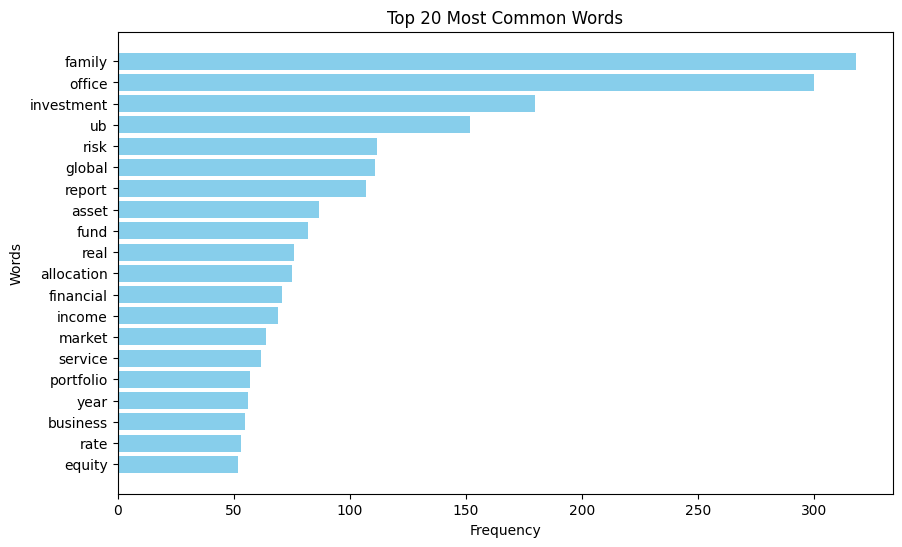

In [47]:
word_freq = get_word_frequency(ubs_lemmatized_words)
plot_most_common_words(word_freq, num=20)

In [52]:
def count_specific_words(tokens, words_to_count):
    word_count = {word: tokens.count(word) for word in words_to_count}
    return word_count

specific_words = ['sustainable', 'impact', 'sustainability', 'ESG', 'environmental', 'philanthropy', 'philanthropic']

# Count occurrences of the specific words in your token list
specific_word_counts = count_specific_words(ubs_lemmatized_words, specific_words)

# Print the count for each specific word
print("Specific Word Counts:")
for word, count in specific_word_counts.items():
    print(f"{word}: {count}")

Specific Word Counts:
sustainable: 2
impact: 21
sustainability: 21
ESG: 0
environmental: 1
philanthropy: 5
philanthropic: 1


#### N-Gram Analysis

In [57]:
documents = [ubs]  # If you're doing one document
# or documents = [cleaned_ubs, cleaned_goldman, ...] for all

# Create a bigram vectorizer
vectorizer = CountVectorizer(ngram_range=(2, 3), stop_words='english')
X = vectorizer.fit_transform(documents)

# Sum up the counts of each bigram
bigrams = vectorizer.get_feature_names_out()
counts = X.toarray().sum(axis=0)

# Create a DataFrame for easy viewing
bigram_freq = pd.DataFrame({'bigram': bigrams, 'count': counts})
bigram_freq = bigram_freq.sort_values(by='count', ascending=False)

# Show top 20 bigrams
print(bigram_freq.head(30))

                         bigram  count
3755             family offices    153
3717              family office    134
4454              global family     87
4456       global family office     86
7109              office report     85
3744       family office report     85
4067               fixed income     50
8603                real estate     49
4254                funds funds     34
8143             private equity     32
805            asset allocation     26
833               asset classes     24
8634                 real rates     22
3142           emerging markets     21
10968                    ubs ag     21
3458                  europe se     21
11037             ubs europe se     21
11036                ubs europe     21
7464         operating business     20
6433           markets emerging     18
2831         direct investments     18
4682                hedge funds     18
4393      geopolitical conflict     18
9005              report global     17
2795          developed m

#### LDA Topic Modelling

In [85]:
custom_stopwords = ['family', 'office', 'ub', 'ubs', 'report', 'investment', 'global', 'risk']
tokens_filtered = [word for word in ubs_lemmatized_words if word not in custom_stopwords]

bigram_model = Phrases([ubs_lemmatized_words], min_count=2, threshold=5)
bigram = Phraser(bigram_model)
bigram_tokens = bigram[ubs_lemmatized_words]

In [87]:
dictionary = corpora.Dictionary([bigram_tokens])

# Step 2: Create corpus (bag of words)
corpus = [dictionary.doc2bow(bigram_tokens)]

In [88]:
lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=3, random_state=42, passes=10)

In [89]:
topics = lda_model.print_topics(num_words=5)
for i, topic in topics:
    print(f"Topic {i+1}: {topic}")

Topic 1: 0.024*"family_office" + 0.014*"investment" + 0.011*"global_family" + 0.011*"office_report" + 0.007*"ub"
Topic 2: 0.001*"family_office" + 0.001*"office_report" + 0.001*"investment" + 0.001*"global_family" + 0.001*"ub"
Topic 3: 0.001*"family_office" + 0.001*"investment" + 0.001*"global_family" + 0.001*"office_report" + 0.001*"allocation"
